In [1]:
# standard libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# system libraries
import os
import sys
from pathlib import Path
# Add the src directory to the path in order to import config
current_directory = Path.cwd()
src_path = current_directory.parent / "src"
sys.path.insert(0, str(src_path))

# project files
import config
import load_option_data_01 as l1
import filter_option_data_01 as f1
import wrds
import bsm_pricer as bsm

# environment variables
WRDS_USERNAME = Path(config.WRDS_USERNAME)
DATA_DIR = Path(config.DATA_DIR)
OUTPUT_DIR = Path(config.OUTPUT_DIR)


# Helper functions

In [20]:
def fit_and_store_curve(group):
    """
    Fit a quadratic curve to the given group of data points and store the fitted values.

    Args:
        group (pandas.DataFrame): The group of data points to fit the curve to.

    Returns:
        pandas.DataFrame: The group of data points with the fitted values stored in the 'fitted_iv' column.
    """
    # Drop rows with NaN in 'moneyness' or 'log_iv'
    # group = group.dropna(subset=['mnyns', 'log_iv'])
    # if len(group) < 3:  # Need at least 3 points to fit a quadratic curve
    #     return group
    try:
        # Fit the quadratic curve
        coefficients = np.polyfit(group['mnyns'], group['log_iv'], 2)
        # Calculate fitted values
        group['fitted_iv'] = np.polyval(coefficients, group['mnyns'])
    except np.RankWarning:
        print("Polyfit may be poorly conditioned")
    return group


In [21]:


def calc_relative_distance(series1, series2, method='percent'):
    """
    Calculate the relative distance between the implied volatility and the fitted implied volatility.
    
    Parameters:
        method (str): The method to calculate the relative distance. Options are 'percent', 'manhattan', or 'euclidean'.
        
    Returns:
        numpy.ndarray: The relative distance calculated based on the specified method.
        
    Raises:
        ValueError: If the method is not one of 'percent', 'manhattan', or 'euclidean'.
    """
    
    if method == 'percent':
        result = (series1 - series2) / series2 * 100
    elif method == 'manhattan':
        result = abs(series1 - series2)
    elif method == 'euclidean':
        result = np.sqrt((series1 - series2)**2)
    else:
        raise ValueError("Method must be 'percent', 'manhattan', or 'euclidean'")
    
    result = np.where(np.isinf(result), np.nan, result)
    
    return result

    
def mark_outliers(row, std_devs, outlier_threshold):
    """
    Determines if a data point is an outlier based on its moneyness_bin and relative distance from the fitted curve.
    
    Args:
        row (pandas.Series): A row of data containing the moneyness_bin and rel_distance columns.
        std_devs (pandas.DataFrame): A DataFrame containing the standard deviations for each moneyness_bin.
    
    Returns:
        bool: True if the data point is an outlier, False otherwise.
    """
    
    # Attempt to retrieve the standard deviation for the row's moneyness_bin
    std_dev_row = std_devs.loc[std_devs['mnyns_bin'] == row['mnyns_bin'], 'std_dev']
    
    # Check if std_dev_row is empty (i.e., no matching moneyness_bin was found)
    if not std_dev_row.empty:
        std_dev = std_dev_row.values[0]
        # Calculate how many std_devs away from the fitted curve the IV is
        if abs(row['rel_distance']) > outlier_threshold * std_dev:  # Adjust this threshold as needed
            return True
    else:
        # Handle the case where no matching moneyness_bin was found
        return False
    return False


def build_put_call_pairs(call_options, put_options):
    """
    Builds pairs of call and put options based on the same date, expiration date, and moneyness.

    Args:
        call_options (DataFrame): DataFrame containing call options data.
        put_options (DataFrame): DataFrame containing put options data.

    Returns:
        tuple of (matching_calls: pd.DataFrame, matching_puts: pd.DataFrame)
    """
    call_options.set_index(['date', 'exdate', 'mnyns'], inplace=True)
    put_options.set_index(['date', 'exdate', 'mnyns'], inplace=True)
    
    # get common indices
    common_index = call_options.index.intersection(put_options.index)

    # Extract the matching entries
    matching_calls = call_options.loc[common_index]
    matching_puts = put_options.loc[common_index]
    
    result = (matching_calls, matching_puts)

    return result


def test_price_strike_match(matching_calls_puts):
    """
    Check if the strike prices and security prices of matching calls and puts are equal.

    Parameters:
    matching_calls_puts (DataFrame): DataFrame containing matching calls and puts data.

    Returns:
    bool: True if the strike prices and security prices of matching calls and puts are equal, False otherwise.
    """
    return (np.allclose(matching_calls_puts['strike_price_C'], matching_calls_puts['strike_price_P'])) and (np.allclose(matching_calls_puts['sec_price_C'], matching_calls_puts['sec_price_P']))# and (np.allclose(matching_calls_puts['tb_m3_C'], matching_calls_puts['tb_m3_P']))


def calc_implied_interest_rate(matched_options):
    """
    Calculates the implied interest rate based on the given matched options data.

    Parameters:
    matched_options (DataFrame): DataFrame containing the matched options data.

    Returns:
    DataFrame: DataFrame with an additional column 'pc_parity_int_rate' representing the implied interest rate.
    
    Raises:
    ValueError: If there is a mismatch between the price and strike price of the options.
    """
    
    # underlying price
    if test_price_strike_match(matched_options):
        print(">> Underlying prices, strike prices of put and call options match exactly.")
        S = matched_options['sec_price_C']
        K = matched_options['strike_price_C']  
        
        # 1/T = 1/time to expiration in years
        T_inv = np.power((matched_options.reset_index()['exdate']-matched_options.reset_index()['date'])/datetime.timedelta(days=365), -1)
        T_inv.index=matched_options.index
        T_inv
        
        C_mid = matched_options['mid_price_C']
        P_mid = matched_options['mid_price_P']
        # implied interest rate
        matched_options['pc_parity_int_rate'] = np.log((S-C_mid+P_mid)/K) * T_inv
        return matched_options
    else:
        raise ValueError("Price and strike price mismatch")


def pcp_filter_outliers(matched_options, int_rate_rel_distance_func, outlier_threshold):
    """
    Filters out outliers based on the relative distance of interest rates and the outlier threshold.

    Parameters:
    - matched_options (DataFrame): DataFrame containing the matched options data.
    - int_rate_rel_distance_func (str): Method to calculate the relative distance of interest rates.
    - outlier_threshold (float): Threshold for flagging outliers.

    Returns:
    - l3_filtered_options (DataFrame): DataFrame with outliers filtered out.

    """

    matched_options['rel_distance_int_rate'] = calc_relative_distance(matched_options['pc_parity_int_rate'], matched_options['daily_median_rate'], method=int_rate_rel_distance_func)
    # fill 3905 nans...
    matched_options['rel_distance_int_rate'] = matched_options['rel_distance_int_rate'].fillna(0.0)

    # calculate the standard deviation of the relative distances
    stdev_int_rate_rel_distance = matched_options['rel_distance_int_rate'].std()

    # flag outliers based on the threshold
    matched_options['is_outlier_int_rate'] = matched_options['rel_distance_int_rate'].abs() > outlier_threshold * stdev_int_rate_rel_distance

    # filter out the outliers
    l3_filtered_options = matched_options[~matched_options['is_outlier_int_rate']]

    # make the dataframe long-form to compare to the level 2 data
    _calls = l3_filtered_options.filter(like='_C').rename(columns=lambda x: x.replace('_C', ''))
    _puts = l3_filtered_options.filter(like='_P').rename(columns=lambda x: x.replace('_P', ''))
    l3_filtered_options = pd.concat((_calls, _puts), axis=0)

    # update the final results for this combination of relative distance method and outlier threshold
    return l3_filtered_options


def iv_filter_outliers(l2_data, iv_distance_method, iv_outlier_threshold):
    """
    Filter out outliers based on the relative distance of log_iv and fitted_iv.

    Parameters:
    l2_data (DataFrame): Input data containing log_iv, fitted_iv, mnyns columns.
    iv_distance_method (str): Method to calculate relative distance of log_iv and fitted_iv.
    iv_outlier_threshold (float): Threshold value to flag outliers.

    Returns:
    DataFrame: Filtered data without outliers.

    """
    l2_data['rel_distance_iv'] = calc_relative_distance(l2_data['log_iv'], l2_data['fitted_iv'], method=iv_distance_method)

    # Define moneyness bins
    bins = np.arange(0.8, 1.21, 0.05)
    l2_data['mnyns_bin'] = pd.cut(l2_data['mnyns'], bins=bins)

    # Compute standard deviation of relative distances within each moneyness bin
    std_devs = l2_data.groupby('mnyns_bin')['rel_distance_iv'].std().reset_index(name='std_dev')
    
    l2_data['stdev_iv_mnyns_bin'] = l2_data['mnyns_bin'].map(std_devs.set_index('mnyns_bin')['std_dev'])
    l2_data['stdev_iv_mnyns_bin'].apply(lambda x: x*iv_outlier_threshold).astype(float)
    # flag outliers based on the threshold
    l2_data['is_outlier_iv'] = l2_data['rel_distance_iv'].abs() > l2_data['stdev_iv_mnyns_bin'].apply(lambda x: x*iv_outlier_threshold).astype(float)

    # filter out the outliers
    l3_data_iv_only = l2_data[~l2_data['is_outlier_iv']]
    
    # update the final results for this combination of relative distance method and outlier threshold
    return l3_data_iv_only


# Table B1 Results for Level 3 Filter (per paper)


In [3]:
check_results = pd.DataFrame(index=pd.MultiIndex.from_product([['Level 3 filters'], ['IV filter', 'Put-call parity filter', 'All']]),
                             columns=pd.MultiIndex.from_product([['Berkeley', 'OptionMetrics'], ['Deleted', 'Remaining']]))
check_results.loc[['Level 3 filters'], ['Berkeley', 'OptionMetrics']] = [[10865, np.nan, 67850, np.nan], [10298, np.nan,46138, np.nan], [np.nan, 173500,np.nan, 962784]]

check_results


Berkeley           OptionMetrics  \
                                        Deleted Remaining       Deleted   
Level 3 filters IV filter                 10865       NaN         67850   
                Put-call parity filter    10298       NaN         46138   
                All                         NaN    173500           NaN   

                                                  
                                       Remaining  
Level 3 filters IV filter                    NaN  
                Put-call parity filter       NaN  
                All                       962784

In [4]:
print(check_results.to_string())

                                       Berkeley           OptionMetrics          
                                        Deleted Remaining       Deleted Remaining
Level 3 filters IV filter                 10865       NaN         67850       NaN
                Put-call parity filter    10298       NaN         46138       NaN
                All                         NaN    173500           NaN    962784


# Implementation of Level 3 Filters: IV Filter

*Methodology*

The process for construction of the IV filter is as follows:

<ol>

<li> The IV filter removes volatility outliers to reduce the prevalence of apparent butterfly arbitrage. This involves dropping calls and puts that have the same expiration date and strike price, but have anomalous prices due to extreme implied volatility values. 

<li> For each *date* and *maturity*, we fit a quadratic curve to the implied volatility of puts and calls (separately) through the observed log implied volatilities

</ol>

In [5]:
# date_range = '1996-01_2012-01'
date_range = '2012-02_2019-12'


# read in L2 filtered data
l2_data = pd.read_parquet(DATA_DIR / f"intermediate/data_{date_range}_L2filter.parquet", columns=['secid', 'date', 'exdate', 'cp_flag', 'mnyns', 'impl_volatility', 'tb_m3', 'best_bid', 'best_offer', 'strike_price', 'contract_size', 'sec_price'])
l2_data
# calc log IV 
l2_data['log_iv'] = np.log(l2_data['impl_volatility'])
l2_data

,secid,date,exdate,cp_flag,mnyns,impl_volatility,tb_m3,best_bid,best_offer,strike_price,contract_size,sec_price,log_iv
1,108105.0,2012-02-02,2012-02-10,C,0.829850,0.363236,0.0008,223.3,226.5,1100.0,100.0,1325.54,-1.012703
2,108105.0,2012-02-03,2012-02-10,C,0.817905,0.573081,0.0008,242.8,246.2,1100.0,100.0,1344.90,-0.556728
3,108105.0,2012-02-03,2012-02-10,C,0.836493,0.530043,0.0008,218.1,221.0,1125.0,100.0,1344.90,-0.634797
8,108105.0,2012-02-16,2012-02-24,C,0.964625,0.217460,0.0010,49.1,51.5,1310.0,100.0,1358.04,-1.525740
9,108105.0,2012-02-16,2012-02-24,P,0.964625,0.200897,0.0010,2.1,2.4,1310.0,100.0,1358.04,-1.604963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346372,108105.0,2019-12-31,2020-02-14,P,1.145234,0.192863,0.0152,463.9,476.4,3700.0,100.0,3230.78,-1.645775
2346373,108105.0,2019-12-31,2020-02-14,P,1.176187,0.223526,0.0152,563.6,576.2,3800.0,100.0,3230.78,-1.498228
2346374,108105.0,2019-12-31,2020-02-28,P,1.145234,0.174623,0.0152,464.4,476.1,3700.0,100.0,3230.78,-1.745126
2346375,108105.0,2019-12-31,2020-02-28,P,1.176187,0.201781,0.0152,564.1,575.7,3800.0,100.0,3230.78,-1.600572


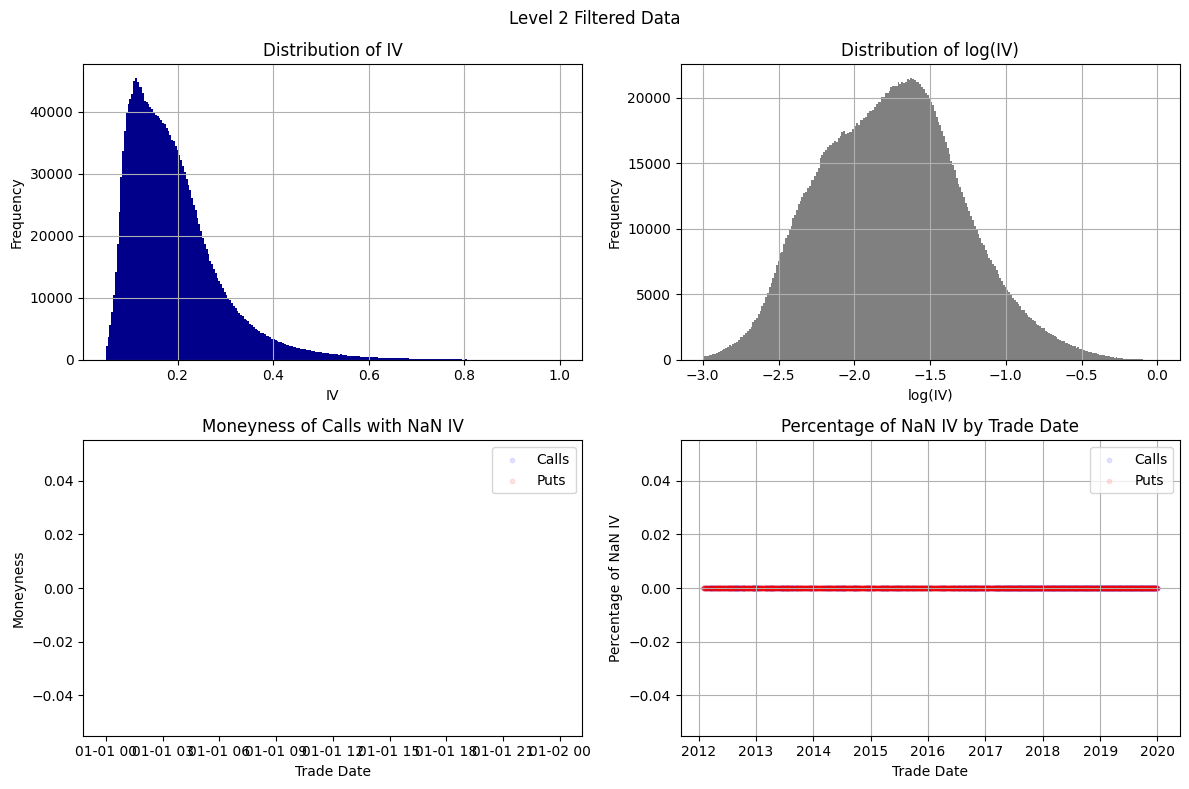

In [6]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

ax[0,0].hist(l2_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l2_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# options with nan implied volatility
# calls only
nan_iv = l2_data[(l2_data['cp_flag'] == 'C') & (l2_data['impl_volatility'].isna())]
ax[1,0].scatter(x=nan_iv['date'], y=nan_iv['mnyns'], color='blue', alpha=0.1, s=10, label='Calls')

# puts only
nan_iv = l2_data[(l2_data['cp_flag'] == 'P') & (l2_data['impl_volatility'].isna())]
ax[1,0].scatter(x=nan_iv['date'], y=nan_iv['mnyns'], color='red', alpha=0.1, s=10, label='Puts')

ax[1,0].set_xlabel('Trade Date')
ax[1,0].set_ylabel('Moneyness')
ax[1,0].set_title('Moneyness of Calls with NaN IV')
ax[1,0].grid()
ax[1,0].legend()
ax[1,0].grid()


# percentage of NaN IV
nan_percentage = l2_data.groupby(['date', 'cp_flag'])['impl_volatility'].apply(lambda x: (x.isna().sum() / len(x))*100)

# calls only
nan_percentage_calls = nan_percentage[nan_percentage.index.get_level_values(1)=='C']
ax[1,1].scatter(x=nan_percentage_calls.index.get_level_values(0), y=nan_percentage_calls.values, color='blue', alpha = 0.1, s=10, label='Calls')

# puts only
nan_percentage_puts = nan_percentage[nan_percentage.index.get_level_values(1)=='P']
ax[1,1].scatter(x=nan_percentage_puts.index.get_level_values(0), y=nan_percentage_puts.values, color='red', alpha = 0.1, s=10, label='Puts')

ax[1,1].set_xlabel('Trade Date')
ax[1,1].set_ylabel('Percentage of NaN IV')
ax[1,1].set_title('Percentage of NaN IV by Trade Date')
ax[1,1].legend()
ax[1,1].grid()

# Hide ax[1,2]
#ax[1,2].axis('off')

plt.suptitle('Level 2 Filtered Data')
plt.tight_layout()
plt.show()

# Noting NaN IV Options in the Level 2 Filtered Data
We note that after the Level 2 filters, there are still several NaNs in the IVs of the remaining options. On any given trade date, the number of NaN IV options reach as high as 50% of the options on a given date. It is also interesting to note that the NaN IVs typically are in options that not near-the-money. However, as we see below, the total number of NaN IV options over the entire dataseries is 3.76% for calls, and 5.67% for puts.

In [7]:
nan_iv_calls = l2_data[(l2_data['cp_flag'] == 'C') & (l2_data['impl_volatility'].isna())]
nan_iv_puts = l2_data[(l2_data['cp_flag'] == 'P') & (l2_data['impl_volatility'].isna())]
nan_iv_summary = pd.DataFrame(index=['Calls', 'Puts'], columns = ['NaN IV Records', 'Total Records', '% NaN IV'])
nan_iv_summary.loc['Calls'] = [len(nan_iv_calls), len(l2_data[l2_data['cp_flag'] == 'C']), len(nan_iv_calls)/len(l2_data[l2_data['cp_flag'] == 'C'])*100]
nan_iv_summary.loc['Puts'] = [len(nan_iv_puts), len(l2_data[l2_data['cp_flag'] == 'P']), len(nan_iv_puts)/len(l2_data[l2_data['cp_flag'] == 'P'])*100]
nan_iv_summary.style.format({'NaN IV Records': '{:,.0f}',
                             'Total Records': '{:,.0f}',
                             '% NaN IV': '{:.2f}%'}).set_caption('Summary of NaN IV Records in Level 2 Filtered Data')


,NaN IV Records,Total Records,% NaN IV
Calls,0,"1,092,427",0.00%
Puts,0,"1,046,735",0.00%


# Removing IV Outliers

The first step in the Level 3 filters is to remove IV outliers from the dataset. To do this, we fit quadratic curves to each set of calls and puts, grouped by date (`date`) and maturity (`exdate`).

In [31]:
# Apply the quadratic curve fitting function to the data
l2_data = l2_data.dropna(subset=['mnyns', 'log_iv']).groupby(['date', 'exdate', 'cp_flag']).filter(lambda group: len(group) >= 3)
    
l2_data = l2_data.groupby(['date', 'exdate', 'cp_flag']).apply(fit_and_store_curve)

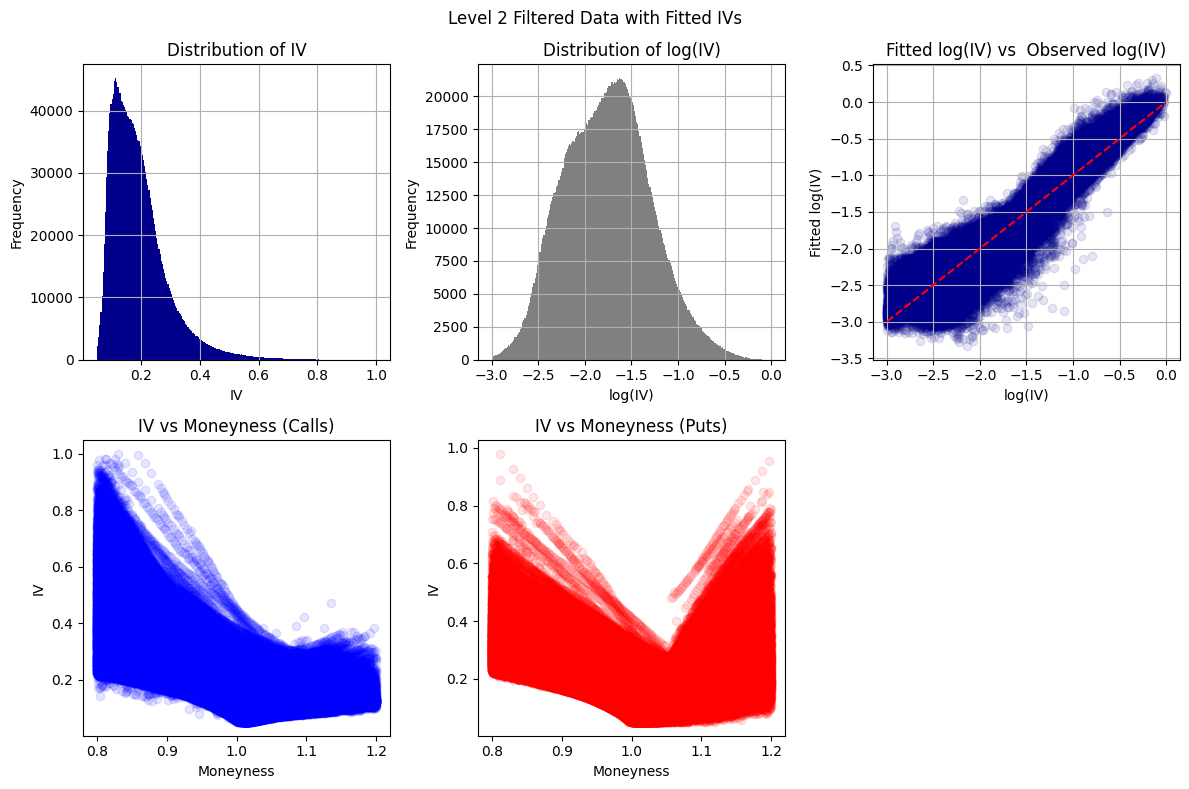

In [32]:
fig, ax = plt.subplots(2,3, figsize=(12,8))

ax[0,0].hist(l2_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l2_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot of IV vs fitted IV
ax[0,2].scatter(x=l2_data['log_iv'], y=l2_data['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('Fitted log(IV) vs  Observed log(IV)')
# Add 45-deg line
ax[0,2].plot([min(l2_data['log_iv']), max(l2_data['log_iv'])], [min(l2_data['log_iv']), max(l2_data['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=l2_data.xs('C', level='cp_flag')['mnyns'], y=np.exp(l2_data.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=l2_data.xs('P', level='cp_flag')['mnyns'], y=np.exp(l2_data.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')

# Hide ax[1,2]
ax[1,2].axis('off')

plt.suptitle('Level 2 Filtered Data with Fitted IVs')
plt.tight_layout()
plt.show()

In [37]:
l3_data_iv_only = iv_filter_outliers(l2_data, 'percent', 2.0)
# convert mnyns_bin to string to save
l3_data_iv_only['mnyns_bin'] = l3_data_iv_only['mnyns_bin'].astype(str)
l3_data_iv_only.to_parquet(DATA_DIR / f"intermediate/data_{date_range}_L3filterIVonly.parquet")

In [38]:
final_result = check_results.loc[:,'OptionMetrics'].copy(deep=True)
final_result.loc[('Level 3 filters', 'IV filter'), 'Deleted'] = len(l2_data)-len(l3_data_iv_only)

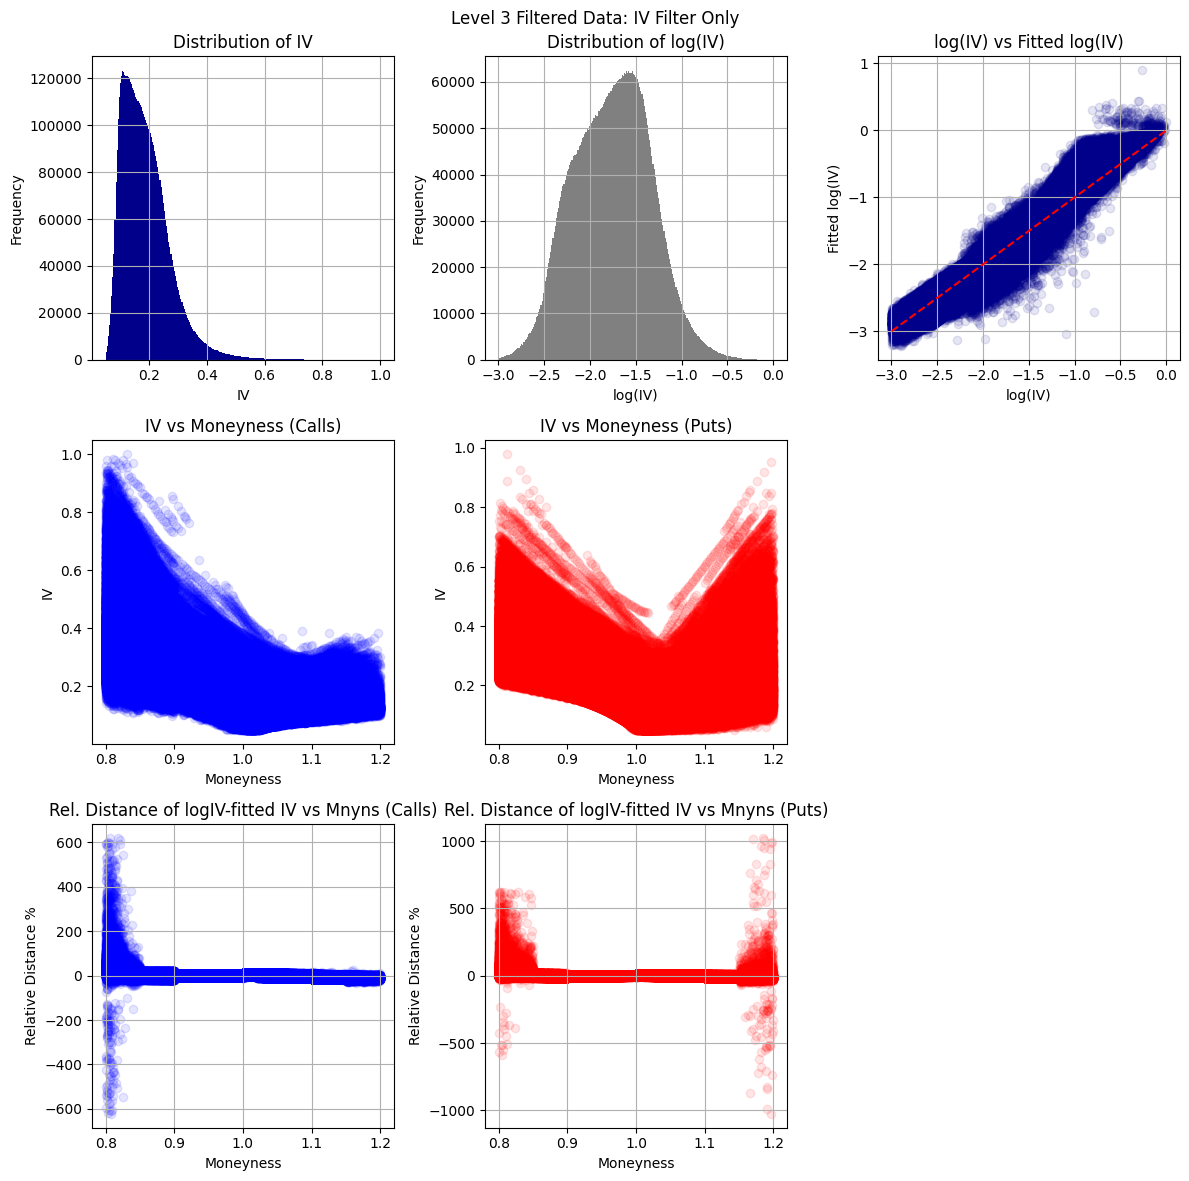

In [39]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

ax[0,0].hist(l3_data_iv_only['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l3_data_iv_only['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot with x=log_iv and y=fitted_iv
ax[0,2].scatter(x=l3_data_iv_only['log_iv'], y=l3_data_iv_only['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('log(IV) vs Fitted log(IV)')
# Add a 45-degree line
ax[0,2].plot([min(l3_data_iv_only['log_iv']), max(l3_data_iv_only['log_iv'])], [min(l3_data_iv_only['log_iv']), max(l3_data_iv_only['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=l3_data_iv_only.xs('C', level='cp_flag')['mnyns'], y=np.exp(l3_data_iv_only.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=l3_data_iv_only.xs('P', level='cp_flag')['mnyns'], y=np.exp(l3_data_iv_only.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')


ax[2,0].scatter(x=l3_data_iv_only.xs('C', level='cp_flag')['mnyns'], y=l3_data_iv_only.xs('C', level='cp_flag')['rel_distance_iv'], color='blue', alpha=0.1, label='Calls')
ax[2,0].set_xlabel('Moneyness')
ax[2,0].set_ylabel('Relative Distance %')
ax[2,0].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Calls)')
ax[2,0].grid()

ax[2,1].scatter(x=l3_data_iv_only.xs('P', level='cp_flag')['mnyns'], y=l3_data_iv_only.xs('P', level='cp_flag')['rel_distance_iv'], color='red', alpha=0.1, label='Puts')
ax[2,1].set_xlabel('Moneyness')
ax[2,1].set_ylabel('Relative Distance %')
ax[2,1].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Puts)')
ax[2,1].grid()

# hide unused subplots
ax[1,2].axis('off')
ax[2,2].axis('off')

plt.suptitle('Level 3 Filtered Data: IV Filter Only')
plt.tight_layout()
plt.show()

In [40]:
ntm_rel_dist = l3_data_iv_only[(l3_data_iv_only['mnyns'] < 1.1) & (l3_data_iv_only['mnyns'] > 0.9)].describe()['rel_distance_iv'].to_frame().rename(columns={'rel_distance_iv': 'Near-The-Money'})
fftm_rel_dist = l3_data_iv_only[(l3_data_iv_only['mnyns'] > 1.1) | (l3_data_iv_only['mnyns'] < 0.9)].describe()['rel_distance_iv'].to_frame().rename(columns={'rel_distance_iv': 'Far-From-The-Money Options'})
rel_dist_stats = pd.concat([ntm_rel_dist, fftm_rel_dist], axis=1)
display(rel_dist_stats.style.format('{:,.2f}').set_caption('Relative Distance Stats'))

,Near-The-Money,Far-From-The-Money Options
count,"3,934,245.00","1,920,391.00"
mean,-0.15,1.11
min,-12.69,"-1,026.84"
25%,-2.57,-2.57
50%,-0.45,0.01
75%,2.04,2.13
max,12.69,"1,021.78"
std,3.79,13.21


We note that the relative distance estimate using the "percent" approach with a 2-standard deviation outlier cutoff threshold is nowhere near what the paper authors indicate (2% near the money, and 3.5% far from the money), as opposed to *-1%* near the money, and *50%* far from the money. Later in this analysis, we will present a sensitivity of the number of options deleted from the dataset with different approaches to distance and different thresholds for the outlier standard deviation cutoff. 

# Level 3 filter: Put-Call Parity

*Methodology*

The process for construction of the Put-Call Parity filter is as follows:

<ol>

<li> The puts and calls need to be matched up based on trading date, expiry date, and option type.

<li> We then calculate the put-call parity implied interest rate, and filter out outliers based on the standard deviation of the relative distance between the PCP implied interest rate, and the calculated daily median 3-month T-bill rate from the pulled data. 

</ol>

In [41]:
l3_data = l3_data_iv_only.copy(deep=True)

# Bid-Ask Midpoint Price and Matching Put-Call Pairs
- Next we calculate the bid-ask midpoint for each option in the dataset, and match put-call pairs. To do this, we need to ensure that for each call option, there's a corresponding put option with the same *strike price* and *expiration date*. 

In [42]:
# calculate bid-ask midpoint
l3_data['mid_price'] = (l3_data['best_bid'] + l3_data['best_offer']) / 2
# extract all the call options
call_options = l3_data.xs('C', level='cp_flag')
call_options
# extract all the put options
put_options = l3_data.xs('P', level='cp_flag')
put_options
matching_calls, matching_puts = build_put_call_pairs(call_options.reset_index(drop=True), put_options.reset_index(drop=True))

# Put-Call Parity Implied Interest Rate
- We now calculate the put-call parity implied interest rate, which can be achieved using: 
$$C-P=S-Ke^{rT}$$
$$e^{rT}=\frac{(S-C+P)}{K}$$
$$r=\frac{1}{T}\cdot log(\frac{S-C+P}{K})$$

In [43]:
# match the puts and calls
matched_options = pd.merge(matching_calls, matching_puts, on=['date', 'exdate', 'mnyns'], suffixes=('_C', '_P'))
# calculate the PCP implied interest rate 
matched_options = calc_implied_interest_rate(matched_options)
matched_options[matched_options['tb_m3_C'].eq(matched_options['tb_m3_P']) == False][['tb_m3_C', 'tb_m3_P']].isna().sum()

# Calculate the daily median implied interest rate from the T-Bill data (same for calls and puts on a given day)
daily_median_int_rate = matched_options.groupby('date')['tb_m3_C'].median().reset_index(name='daily_median_rate')
matched_options = matched_options.join(daily_median_int_rate.set_index('date'), on='date')
matched_options

>> Underlying prices, strike prices of put and call options match exactly.


secid_C cp_flag_C  impl_volatility_C  \
date       exdate     mnyns                                             
2012-02-01 2012-02-18 0.936492  108105.0         C           0.169199   
                      0.940268  108105.0         C           0.170285   
                      0.944045  108105.0         C           0.177905   
                      0.947821  108105.0         C           0.171031   
                      0.951597  108105.0         C           0.173012   
...                                  ...       ...                ...   
2019-12-31 2020-06-19 1.114282  108105.0         C           0.104423   
                      1.122020  108105.0         C           0.105017   
                      1.129758  108105.0         C           0.105596   
                      1.145234  108105.0         C           0.106964   
                      1.176187  108105.0         C           0.110377   

                                tb_m3_C  best_bid_C  best_offer_C  \
date       exdate     mnyns                                         
2012-02-01 2012-02-18 0.936492   0.0006       82.30         84.50   
                      0.940268   0.0006       77.50         79.70   
                      0.944045   0.0006       72.80         75.30   
                      0.947821   0.0006       67.90         70.40   
                      0.951597   0.0006       63.20         66.00   
...                                 ...         ...           ...   
2019-12-31 2020-06-19 1.114282   0.0152        6.60          6.90   
                      1.122020   0.0152        5.40          5.70   
                      1.129758   0.0152        4.40          4.70   
                      1.145234   0.0152        2.95          3.20   
                      1.176187   0.0152        1.35          1.55   

                                strike_price_C  contract_size_C  sec_price_C  \
date       exdate     mnyns                                                    
2012-02-01 2012-02-18 0.936492          1240.0            100.0      1324.09   
                      0.940268          1245.0            100.0      1324.09   
                      0.944045          1250.0            100.0      1324.09   
                      0.947821          1255.0            100.0      1324.09   
                      0.951597          1260.0            100.0      1324.09   
...                                        ...              ...          ...   
2019-12-31 2020-06-19 1.114282          3600.0            100.0      3230.78   
                      1.122020          3625.0            100.0      3230.78   
                      1.129758          3650.0            100.0      3230.78   
                      1.145234          3700.0            100.0      3230.78   
                      1.176187          3800.0            100.0      3230.78   

                                log_iv_C  fitted_iv_C  rel_distance_iv_C  \
date       exdate     mnyns                                                
2012-02-01 2012-02-18 0.936492 -1.776680    -1.685417           5.414836   
                      0.940268 -1.770282    -1.708856           3.594552   
                      0.944045 -1.726506    -1.731223          -0.272509   
                      0.947821 -1.765910    -1.752519           0.764127   
                      0.951597 -1.754394    -1.772743          -1.035047   
...                                  ...          ...                ...   
2019-12-31 2020-06-19 1.114282 -2.259305    -2.250337           0.398534   
                      1.122020 -2.253633    -2.267395          -0.606970   
                      1.129758 -2.248135    -2.284252          -1.581135   
                      1.145234 -2.235263    -2.317359          -3.542637   
                      1.176187 -2.203854    -2.381147          -7.445725   

                                mnyns_bin_C stdev_iv_mnyns_bin_C  \
date       exdate     mnyns                                        
2012-02-01 2012-02-

In [44]:
l3_filtered_options = pcp_filter_outliers(matched_options, 'percent', 2.0)
l3_filtered_options

secid cp_flag  impl_volatility   tb_m3  \
date       exdate     mnyns                                                 
2012-02-01 2012-02-18 0.936492  108105.0       C         0.169199  0.0006   
                      0.940268  108105.0       C         0.170285  0.0006   
                      0.944045  108105.0       C         0.177905  0.0006   
                      0.947821  108105.0       C         0.171031  0.0006   
                      0.951597  108105.0       C         0.173012  0.0006   
...                                  ...     ...              ...     ...   
2019-12-31 2020-06-19 1.114282  108105.0       P         0.110290  0.0152   
                      1.122020  108105.0       P         0.111127  0.0152   
                      1.129758  108105.0       P         0.112514  0.0152   
                      1.145234  108105.0       P         0.115693  0.0152   
                      1.176187  108105.0       P         0.123331  0.0152   

                                best_bid  best_offer  strike_price  \
date       exdate     mnyns                                          
2012-02-01 2012-02-18 0.936492      82.3        84.5        1240.0   
                      0.940268      77.5        79.7        1245.0   
                      0.944045      72.8        75.3        1250.0   
                      0.947821      67.9        70.4        1255.0   
                      0.951597      63.2        66.0        1260.0   
...                                  ...         ...           ...   
2019-12-31 2020-06-19 1.114282     371.4       378.7        3600.0   
                      1.122020     392.2       404.8        3625.0   
                      1.129758     416.0       428.6        3650.0   
                      1.145234     464.1       476.7        3700.0   
                      1.176187     561.6       574.1        3800.0   

                                contract_size  sec_price    log_iv  fitted_iv  \
date       exdate     mnyns                                                     
2012-02-01 2012-02-18 0.936492          100.0    1324.09 -1.776680  -1.685417   
                      0.940268          100.0    1324.09 -1.770282  -1.708856   
                      0.944045          100.0    1324.09 -1.726506  -1.731223   
                      0.947821          100.0    1324.09 -1.765910  -1.752519   
                      0.951597          100.0    1324.09 -1.754394  -1.772743   
...                                       ...        ...       ...        ...   
2019-12-31 2020-06-19 1.114282          100.0    3230.78 -2.204642  -2.195065   
                      1.122020          100.0    3230.78 -2.197082  -2.208213   
                      1.129758          100.0    3230.78 -2.184678  -2.220981   
                      1.145234          100.0    3230.78 -2.156815  -2.245377   
                      1.176187          100.0    3230.78 -2.092883  -2.289608   

                                rel_distance_iv    mnyns_bin  \
date       exdate     mnyns                                    
2012-02-01 2012-02-18 0.936492         5.414836  (0.9, 0.95]   
                      0.940268         3.594552  (0.9, 0.95]   
                      0.944045        -0.272509  (0.9, 0.95]   
                      0.947821         0.764127  (0.9, 0.95]   
                      0.951597        -1.035047  (0.95, 1.0]   
...                                         ...          ...   
2019-12-31 2020-06-19 1.114282         0.436282  (1.1, 1.15]   
                      1.122020        -0.504106  (1.1, 1.15]   
                      1.129758        -1.634577  (1.1, 1.15]   
                      1.145234        -3.944190  (1.1, 1.15]   
                      1.176187        -8.592076  (1.15, 1.2]   

                               stdev_iv_mnyns_bin  is_outlier_iv  mid_price  
date       exdate     mnyns                                                  
2012-02-01 2012-02-18 0.936492           3.805669          False      83.40  
 

In [45]:
final_result.loc[('Level 3 filters', 'Put-call parity filter'), 'Deleted'] = len(l3_data_iv_only)-len(l3_filtered_options)
final_result.loc[('Level 3 filters', 'All'), 'Remaining'] = len(l3_filtered_options)
final_result

Deleted Remaining
Level 3 filters IV filter                414773       NaN
                Put-call parity filter  1103026       NaN
                All                         NaN   4752640

In [46]:
l3_filter_final_result = pd.merge(final_result, check_results.loc[:, 'OptionMetrics'], left_index=True, right_index=True, suffixes=(' - HamHolDes', ' - OptionMetrics')).style.format('{:,.0f}')
l3_filter_final_result

In [47]:
l3_filtered_options

secid cp_flag  impl_volatility   tb_m3  \
date       exdate     mnyns                                                 
2012-02-01 2012-02-18 0.936492  108105.0       C         0.169199  0.0006   
                      0.940268  108105.0       C         0.170285  0.0006   
                      0.944045  108105.0       C         0.177905  0.0006   
                      0.947821  108105.0       C         0.171031  0.0006   
                      0.951597  108105.0       C         0.173012  0.0006   
...                                  ...     ...              ...     ...   
2019-12-31 2020-06-19 1.114282  108105.0       P         0.110290  0.0152   
                      1.122020  108105.0       P         0.111127  0.0152   
                      1.129758  108105.0       P         0.112514  0.0152   
                      1.145234  108105.0       P         0.115693  0.0152   
                      1.176187  108105.0       P         0.123331  0.0152   

                                best_bid  best_offer  strike_price  \
date       exdate     mnyns                                          
2012-02-01 2012-02-18 0.936492      82.3        84.5        1240.0   
                      0.940268      77.5        79.7        1245.0   
                      0.944045      72.8        75.3        1250.0   
                      0.947821      67.9        70.4        1255.0   
                      0.951597      63.2        66.0        1260.0   
...                                  ...         ...           ...   
2019-12-31 2020-06-19 1.114282     371.4       378.7        3600.0   
                      1.122020     392.2       404.8        3625.0   
                      1.129758     416.0       428.6        3650.0   
                      1.145234     464.1       476.7        3700.0   
                      1.176187     561.6       574.1        3800.0   

                                contract_size  sec_price    log_iv  fitted_iv  \
date       exdate     mnyns                                                     
2012-02-01 2012-02-18 0.936492          100.0    1324.09 -1.776680  -1.685417   
                      0.940268          100.0    1324.09 -1.770282  -1.708856   
                      0.944045          100.0    1324.09 -1.726506  -1.731223   
                      0.947821          100.0    1324.09 -1.765910  -1.752519   
                      0.951597          100.0    1324.09 -1.754394  -1.772743   
...                                       ...        ...       ...        ...   
2019-12-31 2020-06-19 1.114282          100.0    3230.78 -2.204642  -2.195065   
                      1.122020          100.0    3230.78 -2.197082  -2.208213   
                      1.129758          100.0    3230.78 -2.184678  -2.220981   
                      1.145234          100.0    3230.78 -2.156815  -2.245377   
                      1.176187          100.0    3230.78 -2.092883  -2.289608   

                                rel_distance_iv    mnyns_bin  \
date       exdate     mnyns                                    
2012-02-01 2012-02-18 0.936492         5.414836  (0.9, 0.95]   
                      0.940268         3.594552  (0.9, 0.95]   
                      0.944045        -0.272509  (0.9, 0.95]   
                      0.947821         0.764127  (0.9, 0.95]   
                      0.951597        -1.035047  (0.95, 1.0]   
...                                         ...          ...   
2019-12-31 2020-06-19 1.114282         0.436282  (1.1, 1.15]   
                      1.122020        -0.504106  (1.1, 1.15]   
                      1.129758        -1.634577  (1.1, 1.15]   
                      1.145234        -3.944190  (1.1, 1.15]   
                      1.176187        -8.592076  (1.15, 1.2]   

                               stdev_iv_mnyns_bin  is_outlier_iv  mid_price  
date       exdate     mnyns                                                  
2012-02-01 2012-02-18 0.936492           3.805669          False      83.40  
 

In [48]:
l3_filtered_options.reset_index().set_index(['date', 'exdate', 'cp_flag'])
l3_filtered_options.to_parquet(DATA_DIR / f"intermediate/data_{date_range}_L3filter.parquet")

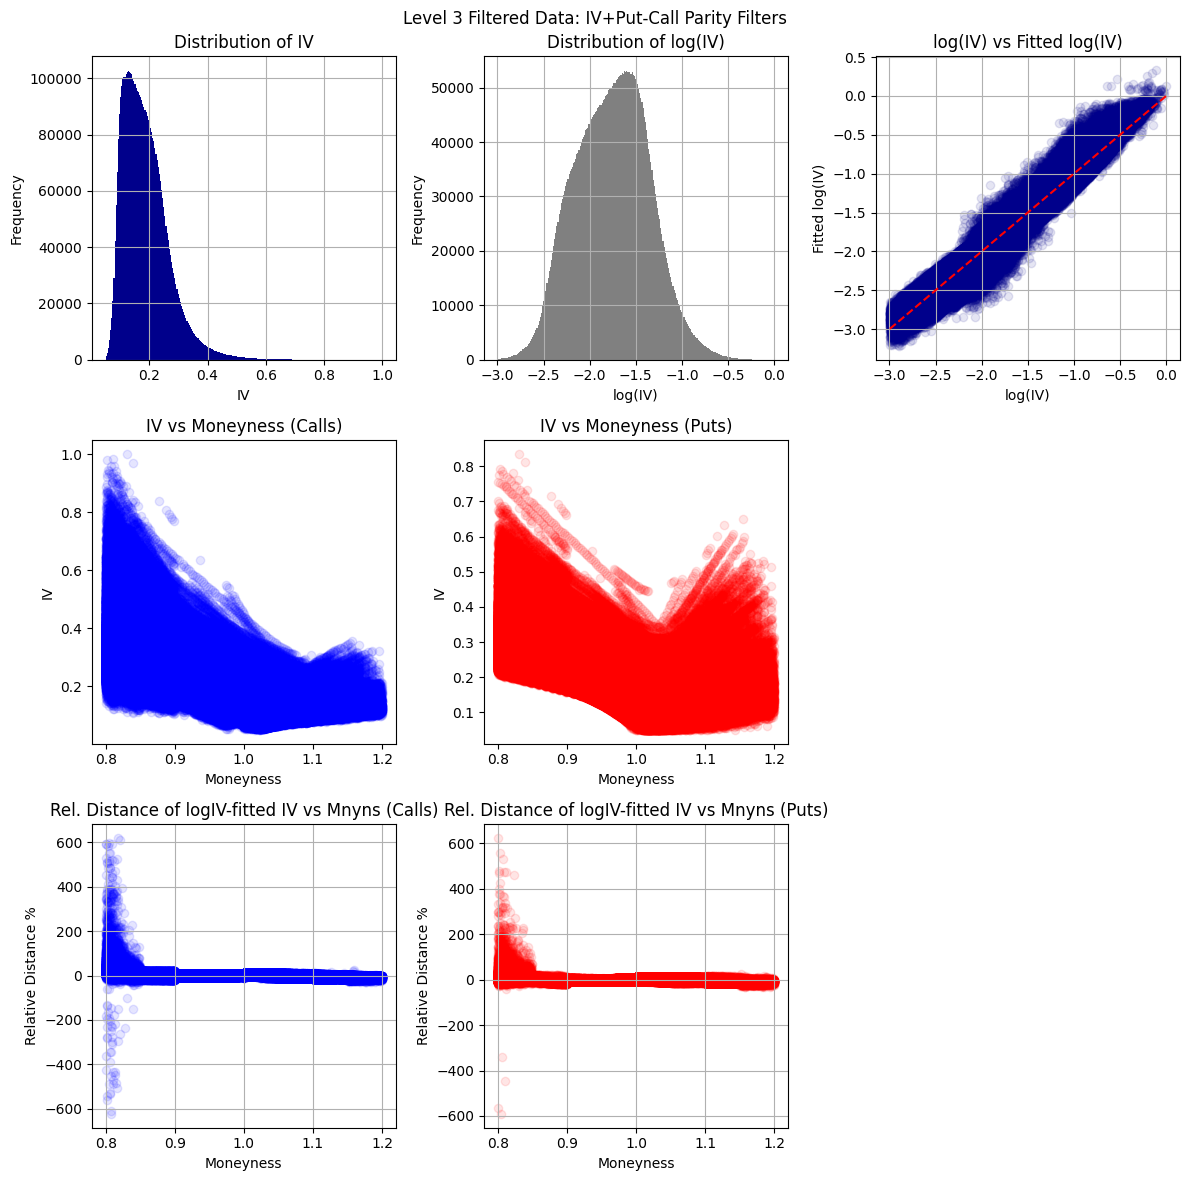

In [49]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

chart_data = l3_filtered_options.reset_index().set_index(['date', 'exdate', 'cp_flag'])

ax[0,0].hist(chart_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(chart_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot with x=log_iv and y=fitted_iv
ax[0,2].scatter(x=chart_data['log_iv'], y=chart_data['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('log(IV) vs Fitted log(IV)')
# Add a 45-degree line
ax[0,2].plot([min(chart_data['log_iv']), max(chart_data['log_iv'])], [min(chart_data['log_iv']), max(chart_data['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=chart_data.xs('C', level='cp_flag')['mnyns'], y=np.exp(chart_data.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=chart_data.xs('P', level='cp_flag')['mnyns'], y=np.exp(chart_data.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')


ax[2,0].scatter(x=chart_data.xs('C', level='cp_flag')['mnyns'], y=chart_data.xs('C', level='cp_flag')['rel_distance_iv'], color='blue', alpha=0.1, label='Calls')
ax[2,0].set_xlabel('Moneyness')
ax[2,0].set_ylabel('Relative Distance %')
ax[2,0].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Calls)')
ax[2,0].grid()

ax[2,1].scatter(x=chart_data.xs('P', level='cp_flag')['mnyns'], y=chart_data.xs('P', level='cp_flag')['rel_distance_iv'], color='red', alpha=0.1, label='Puts')
ax[2,1].set_xlabel('Moneyness')
ax[2,1].set_ylabel('Relative Distance %')
ax[2,1].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Puts)')
ax[2,1].grid()

# hide unused subplots
ax[1,2].axis('off')
ax[2,2].axis('off')

plt.suptitle('Level 3 Filtered Data: IV+Put-Call Parity Filters')
plt.tight_layout()
plt.show()

## Sensitivity of the Level 3 Filters
- The options deleted at each stage of the Level 3 filters (as described in the paper) are very sensitive to the distance function utilized and the outlier threshold. Below we analyze the sensitivity of the number of options deleted to variation in the distance function (percent distance, Manhattan (absolute) distance, and Euclidean distance), as well as to a range of 2 to 5 standard deviations to drop outliers. 
- Since similar filters are used for the **Implied Volatility Filter** as well as the **Put-Call Parity Filter**, errors in filter construction can have significant downstream effects, as we see in the sensitivity table results below. 

In [50]:
distance_functions = ['percent', 'manhattan', 'euclidean']
outlier_thresholds = [2., 2.5, 3., 3.5, 4., 4.5, 5.] # stdevs

# dataframe to store sensitivity results
pcp_filter_sens = pd.DataFrame(index=pd.MultiIndex.from_product([distance_functions, outlier_thresholds]),
                                      columns=['Deleted', 'Remaining'])
pcp_filter_sens.index.names = ['Rel. Dist. Method', 'Outlier Stdev Thresh.']

iv_filter_sens = pd.DataFrame(index=pd.MultiIndex.from_product([distance_functions, outlier_thresholds]),
                                      columns=['Deleted', 'Remaining'])
iv_filter_sens.index.names = ['Rel. Dist. Method', 'Outlier Stdev Thresh.']

# run sensitivity analysis
for dist in distance_functions:
    for thresh in outlier_thresholds:
        print('Running sensitivity analysis for distance function:', dist, 'and outlier threshold:', thresh)
        l3_data_iv_only = iv_filter_outliers(l2_data, dist, thresh)
        iv_filter_sens.loc[(dist, thresh), :] = {'Deleted' : len(l2_data)-len(l3_data_iv_only),
                                                 'Remaining': len(l3_data_iv_only)}
        
        l3_filtered_options = pcp_filter_outliers(matched_options, dist, thresh)
        pcp_filter_sens.loc[(dist, thresh), :] = {'Deleted' : len(l3_data_iv_only) - len(l3_filtered_options),
                                                                                 'Remaining': len(l3_filtered_options)}

Running sensitivity analysis for distance function: percent and outlier threshold: 2.0
Running sensitivity analysis for distance function: percent and outlier threshold: 2.5
Running sensitivity analysis for distance function: percent and outlier threshold: 3.0
Running sensitivity analysis for distance function: percent and outlier threshold: 3.5
Running sensitivity analysis for distance function: percent and outlier threshold: 4.0
Running sensitivity analysis for distance function: percent and outlier threshold: 4.5
Running sensitivity analysis for distance function: percent and outlier threshold: 5.0
Running sensitivity analysis for distance function: manhattan and outlier threshold: 2.0
Running sensitivity analysis for distance function: manhattan and outlier threshold: 2.5
Running sensitivity analysis for distance function: manhattan and outlier threshold: 3.0
Running sensitivity analysis for distance function: manhattan and outlier threshold: 3.5
Running sensitivity analysis for di

In [51]:
l3_sens_table = pd.merge(iv_filter_sens, pcp_filter_sens, left_index=True, right_index=True, suffixes=(' - Post-IV', ' - Post-PCP'))
l3_sens_table.style.format('{:,.0f}')
l3_sens_table

Deleted - Post-IV Remaining - Post-IV  \
Rel. Dist. Method Outlier Stdev Thresh.                                         
percent           2.0                              414773             5855666   
                  2.5                              216013             6054426   
                  3.0                              112511             6157928   
                  3.5                               58516             6211923   
                  4.0                               30620             6239819   
                  4.5                               16503             6253936   
                  5.0                                9531             6260908   
manhattan         2.0                              840846             5429593   
                  2.5                              498908             5771531   
                  3.0                              298637             5971802   
                  3.5                              180919             6089520   
                  4.0                              109244             6161195   
                  4.5                               66478             6203961   
                  5.0                               41599             6228840   
euclidean         2.0                              840846             5429593   
                  2.5                              498908             5771531   
                  3.0                              298637             5971802   
                  3.5                              180919             6089520   
                  4.0                              109244             6161195   
                  4.5                               66478             6203961   
                  5.0                               41599             6228840   

                                        Deleted - Post-PCP  \
Rel. Dist. Method Outlier Stdev Thresh.                      
percent           2.0                              1103026   
                  2.5                              1203100   
                  3.0                              1246678   
                  3.5                              1250037   
                  4.0                              1236945   
                  4.5                              1221774   
                  5.0                              1208462   
manhattan         2.0                              1803347   
                  2.5                              1430223   
                  3.0                              1216488   
                  3.5                              1181306   
                  4.0                              1179797   
                  4.5                              1185169   
                  5.0                              1185886   
euclidean         2.0                              1803347   
                  2.5                              1430223   
                  3.0                              1216488   
                  3.5                              1181306   
                  4.0                              1179797   
                  4.5                              1185169   
                  5.0                              1185886   

                                        Remaining - Post-PCP  
Rel. Dist. Method Outlier Stdev Thresh.                       
percent           2.0                                4752640  
                  2.5                                4851326  
                  3.0                                4911250  
                  3.5                                4961886  
                  4.0                                5002874  
                  4.5                                5032162  
                  5.0                                5052446  
manhattan         2.0                                3626246  
                  2.5                                4341308  
                  3.0                                475

In [52]:
error_in_iv_deletions = (l3_sens_table['Deleted - Post-IV'] / check_results.loc[('Level 3 filters', 'IV filter'), 'OptionMetrics']['Deleted'] - 1).to_frame().rename(columns={'Deleted - Post-IV': '% Error in IV Deletions'})
error_in_pcp_deletions = (l3_sens_table['Deleted - Post-PCP'] / check_results.loc[('Level 3 filters', 'Put-call parity filter'), 'OptionMetrics']['Deleted'] - 1).to_frame().rename(columns={'Deleted - Post-PCP': '% Error in PCP Deletions'})
error_in_final_res = (l3_sens_table['Remaining - Post-PCP'] / check_results.loc[('Level 3 filters', 'All'), 'OptionMetrics']['Remaining'] - 1).to_frame().rename(columns={'Remaining - Post-PCP': '% Error Final Option Count'})

error_in_deletions = pd.concat((error_in_iv_deletions, error_in_pcp_deletions, error_in_final_res), axis=1)
display(error_in_deletions.style.format('{:.1%}'))

# Comments on Final Result
- Our final option set seems to distributed in a fairly well-behaved volatility curve, when plotted against moneyness, with a prominent "volatility smirk" for options with moneyness < 1.0. 
- We note that the final option counts from our implementation are mostly within 5% - 10% of Table B1 in the paper, which is surprisingly close, given the number of judgment calls that needed to be made with regard to the filter methodology. 
- This suggests that further efforts to reproduce the paper's results might be challenging, since it is quite likely that the specific composition of options in our final dataset might not correspond exactly with those in the paper, despite our best efforts at reproducing the filters as described. 

---

# Implied Volatilities based on Put-Call Parity Implied Interest Rate
Next we compute implied volatilities based on the put-call parity implied interest rate, and compare them to the T-bill implied volatilities. 

In [ ]:
# TODO